This notebook takes the fix cutoff save groups (every 300 ROIs), and converts to save group based on patient IDs so that all patients are guaranteed to be saved into one group.

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
from skimage.color import label2rgb
import json
# import nrrd

import pandas as pd
import seaborn as sns
# Project Root
# used for searching packages and functions
# TODO: enter your project root dir here
ROOT_DIR = '/project/Xie_Lab/zgu/xiao_multiplex/multiTAP/image_cytof'

sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution
from cytof.classes import CytofImageTiff
from cytof.classes import CytofCohort

/project/Xie_Lab/zgu/conda_stuff/envs/cytof-shared/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_roi_id(roi_id):
    try:

        # first split by _
        split = roi_id.split('_')
        # special case for 178 A and C
        if roi_id.startswith('178_A') or roi_id.startswith('178_C'):
            return f"{split[0]}_{split[2]}{split[3]},{split[4]}"
        elif roi_id.startswith('178_B'): # special case for 178 B
            return f"{split[0]}_{split[3]}{split[4]},{split[5]}"
        else: # all other cases
            return f"{split[0]}_{split[2]},{split[3]}"
    except IndexError:
        return None  # or raise an error / return roi_id unchanged


In [3]:
# add the clinical data
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
# pt_subset = pt_clinical_data[pt_clinical_data['RoiID'].isin(roi_id_list)]
pt_subset = pt_clinical_data[['RoiID','Patient_ID', 'OS', 'DFS', 'Ev.O']]
# pt_subset['OS_one_Year'] = pt_subset['OS'] > 365

# first exclude control from survival analysis (no OS info)
pt_subset = pt_subset[pt_subset['Patient_ID'] != 'Control']
pt_subset

,RoiID,Patient_ID,OS,DFS,Ev.O
0,"175_A1,1",175_1,254.0,NaN,1.0
1,"175_A1,2",175_5,3420.0,3420.0,1.0
2,"175_A1,3",175_9,1312.0,1312.0,1.0
3,"175_A1,4",175_13,1950.0,1950.0,1.0
4,"175_A1,6",175_21,820.0,820.0,1.0
...,...,...,...,...,...
2065,"88_C8,9",88_521,596.0,370.0,1.0
2066,"88_C8,10",88_525,323.0,323.0,1.0
2067,"88_C8,11",88_529,1707.0,1707.0,0.0
2068,"88_C8,12",88_533,1652.0,1652.0,0.0


In [ ]:
# load save_group info
save_group1 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_all.csv")
save_group2 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_group175_only.csv")

# exclude two pt that had multiple acuisition IDs (Known issue, page e4 of the paper)
exclude_roi_list = ['88_A_A4_2', '88_A_A5_2', '88_A_A3_2'] # 88_A_A3_2 is a different ROI belong to the same patient of the other excluded ROI
save_group1 = save_group1[~save_group1['ROI'].isin(exclude_roi_list)]

# exclude ROI with inconsistent group label
# all other prefix ROIs have format prefix_A_Axxx, ..., prefix_C_Cxxx
save_group2 = save_group2[~save_group2['ROI'].str.startswith("175_B_A")]

save_group_all = pd.concat([save_group1, save_group2]).reset_index(drop=True)
save_group_all['roi_mappable'] = save_group_all['ROI'].apply(extract_roi_id)

# merge with clinical info
pt_id_savegroup = save_group_all.merge(pt_subset, how='inner', left_on='roi_mappable', right_on='RoiID')
# save_path = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/roi_pt_id_mapping.csv'
# pt_id_savegroup.to_csv(save_path, index=False)

pt_id_savegroup


,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1","86_A1,1",86_1,2593.0,2593.0,1.0
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2","86_A1,2",86_5,158.0,158.0,1.0
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5","86_A1,5",86_17,121.0,NaN,1.0
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6","86_A1,6",86_21,521.0,521.0,1.0
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7","86_A1,7",86_25,2382.0,1250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1947,NSCLC_ALL,175_C_C8_10,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,10","175_C8,10",175_176,944.0,829.0,1.0
1948,NSCLC_ALL,175_C_C8_11,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,11","175_C8,11",175_180,1061.0,1061.0,1.0
1949,NSCLC_ALL,175_C_C8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,12","175_C8,12",175_184,3027.0,3027.0,0.0
1950,NSCLC_ALL,175_C_C8_13,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,13","175_C8,13",175_188,1458.0,1255.0,1.0


In [11]:
# save_group_all[save_group_all['ROI'].str.startswith("175_B_B2")]
roi_per_pt = pt_id_savegroup.groupby('Patient_ID')[['ROI']].nunique()

print('maximum ROI per pt:', max(roi_per_pt['ROI']))


maximum ROI per pt: 2


In [14]:
# redistribute_group = [86, 87, 88, 175, 176, 178] 
redistribute_group = [175, 176, 178]

BASE_PKL_DIR = "/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work"
DIR_OUT = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work'


# going through each prefix
for prefix in redistribute_group:
    per_prefix_roi = pt_id_savegroup[pt_id_savegroup['ROI'].str.startswith(f'{prefix}_')].reset_index(drop=True)

    # get the save_group # this prefix has been saved across
    save_groups = np.unique(per_prefix_roi['save_group'])

    cytof_imgs_new_dict = dict()

    # for each save_group
    for group in save_groups:
        # get all ROI in this save_group
        roi_imgs_in_save_group = per_prefix_roi[per_prefix_roi['save_group']==group].reset_index(drop=True)
        per_save_group_roi_list = roi_imgs_in_save_group['ROI']
        
        pkl_dir = os.path.join(BASE_PKL_DIR, f'nsclc_save_group{group}', f'nsclc_save_group{group}.pkl')
        cytof_cohort_whole_slide = pkl.load(open(pkl_dir, 'rb'))
        print(f'loaded file {pkl_dir}')

        for ind_roi in per_save_group_roi_list:
            # save all cytof_imgs to the new dict
            new_key = f"NSCLC_ALL_{ind_roi}"
            cytof_imgs_new_dict[new_key] = cytof_cohort_whole_slide.cytof_images[new_key]
        
        print(len(per_save_group_roi_list), 'ROIs saved from group', group)

    # make sure number of ROIs in prefix df and new dict matches    
    assert len(per_prefix_roi) == len(cytof_imgs_new_dict.keys())

    # create the new CytofCohort
    new_cohort = CytofCohort(cytof_images=cytof_imgs_new_dict, df_cohort=per_prefix_roi, cohort_name=f'nsclc_save_group{prefix}', dir_out=DIR_OUT)
    save_path = new_cohort.save_cytof_cohort()

    print(f'Results saved to {save_path}')

loaded file /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group175/nsclc_save_group175.pkl
361 ROIs saved from group 175
Output folder created: /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group175
Results saved to /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group175/nsclc_save_group175.pkl
loaded file /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group4/nsclc_save_group4.pkl
186 ROIs saved from group 4
loaded file /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group5/nsclc_save_group5.pkl
164 ROIs saved from group 5
Output folder created: /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group176
Results saved to /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group176/nsclc_save_group176.pkl
loaded file /project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group2/nsclc_save_group2.pkl
258 ROIs saved from group 2
loaded file /proje

# Sanity check
quick check by loading the same patient from 1) the new pkl file, and 2) the old pkl file; then compare their cohort.co_expression output

## load from the same file

In [10]:
pt_87 = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group87/nsclc_save_group87.pkl'
cytof_cohort_87 = pkl.load(open(pt_87, 'rb'))


In [16]:
pt_id = '87_325'
df_cohort = cytof_cohort_87.df_cohort.copy()
df_to_load = df_cohort[df_cohort['Patient_ID']==pt_id]
df_to_load

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
339,NSCLC_ALL,87_C_C7_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,1,"87_C7,7","87_C7,7",87_325,2974.0,2974.0,0.0
354,NSCLC_ALL,87_C_C8_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,2,"87_C8,7","87_C8,7",87_325,2974.0,2974.0,0.0


In [29]:
per_ptp_roi_list = df_to_load['ROI']
per_pt_roi_dict = dict()

# load the same pt ROI into one cohort
for ind_roi in per_ptp_roi_list:
    # save all cytof_imgs to the new dict
    new_key = f"NSCLC_ALL_{ind_roi}"
    per_pt_roi_dict[new_key] = cytof_cohort_87.cytof_images[new_key]

# df_cohort not saved, creating one automatically from CytofCohort
per_pt_cohort = CytofCohort(cytof_images=per_pt_roi_dict,  dir_out=None)
per_pt_cohort.batch_process_feature()
per_pt_cohort.generate_summary()

Getting thresholds for cell sum of all markers.


['75normed_sum']

Text(0.5, 1.0, 'NSCLC_ALL')

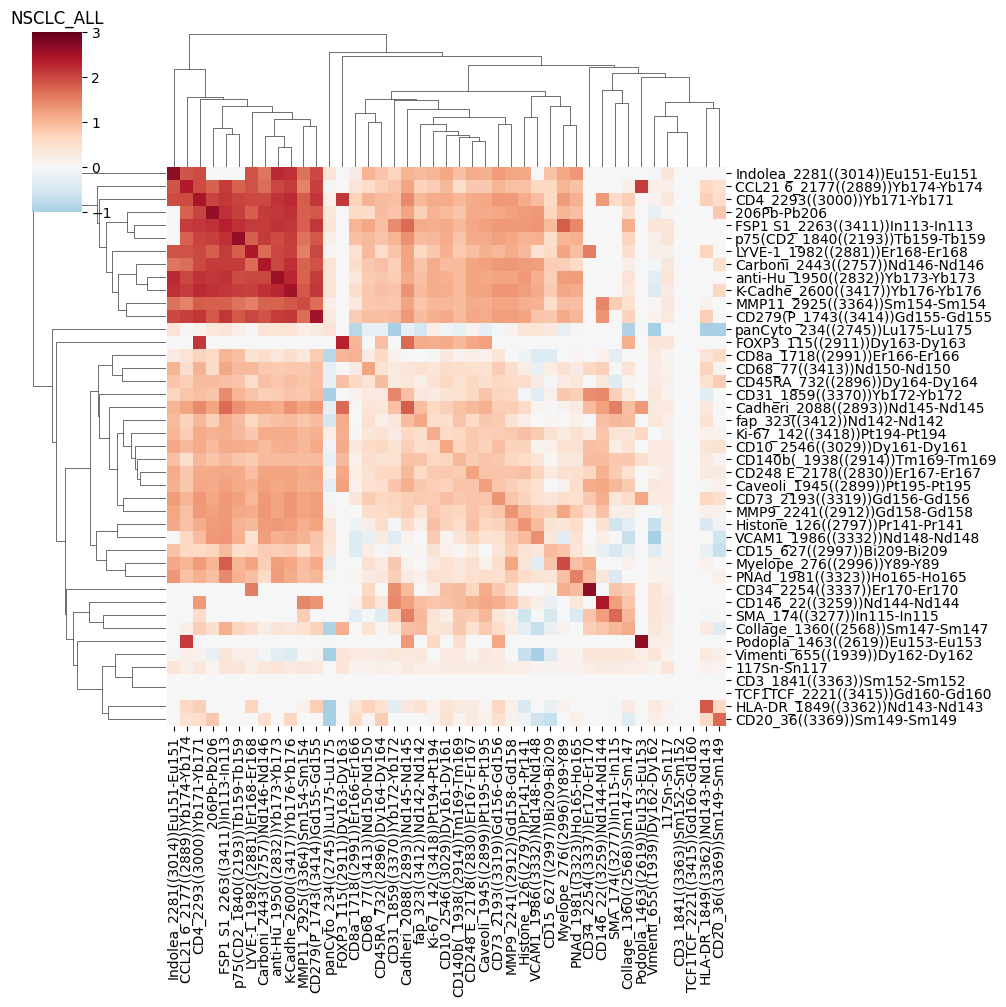

In [31]:
%matplotlib inline
slide_co_expression_dict = per_pt_cohort.co_expression_analysis()

edge_percentage_norm, column_names = slide_co_expression_dict['NSCLC_ALL']

# post processing
column_names_clean = [m.replace('_cell_sum', '') for m in column_names]
epsilon = 1e-6 # avoid divide by 0 or log(0)
clustergrid = sns.clustermap(edge_percentage_norm,
                            # clustergrid = sns.clustermap(edge_percentage_norm,
                            center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                            xticklabels=column_names_clean, yticklabels=column_names_clean)
plt.title('NSCLC_ALL')

## load from different files

In [32]:
save_group1 = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group1/nsclc_save_group1.pkl'
save_group2 = '/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group2/nsclc_save_group2.pkl'

cytof_cohort_1 = pkl.load(open(save_group1, 'rb'))
cytof_cohort_2 = pkl.load(open(save_group2, 'rb'))



In [33]:
per_pt_roi_dict

{'NSCLC_ALL_87_C_C7_7': CytofImage(slide=NSCLC_ALL, roi=87_C_C7_7),
 'NSCLC_ALL_87_C_C8_7': CytofImage(slide=NSCLC_ALL, roi=87_C_C8_7)}

Getting thresholds for cell sum of all markers.


Text(0.5, 1.0, 'NSCLC_ALL')

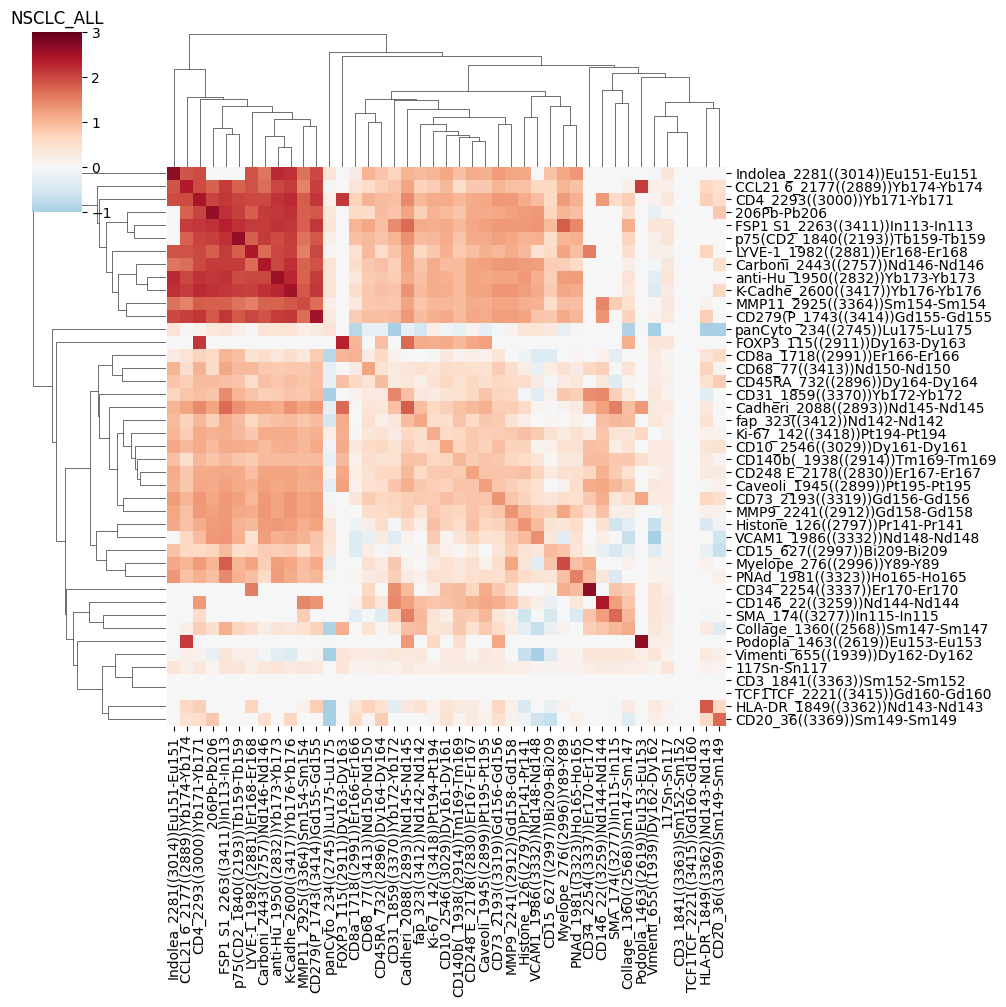

In [35]:
cytof_img1 = cytof_cohort_1['NSCLC_ALL_87_C_C7_7']
cytof_img2 = cytof_cohort_2['NSCLC_ALL_87_C_C8_7']

sep_roi_dict = {'NSCLC_ALL_87_C_C7_7':cytof_img1, 'NSCLC_ALL_87_C_C8_7':cytof_img2}
# df_cohort not saved, creating one automatically from CytofCohort
per_pt_cohort = CytofCohort(cytof_images=sep_roi_dict,  dir_out=None)
per_pt_cohort.batch_process_feature()
per_pt_cohort.generate_summary()

slide_co_expression_dict = per_pt_cohort.co_expression_analysis()

edge_percentage_norm, column_names = slide_co_expression_dict['NSCLC_ALL']

# post processing
column_names_clean = [m.replace('_cell_sum', '') for m in column_names]
epsilon = 1e-6 # avoid divide by 0 or log(0)
clustergrid = sns.clustermap(edge_percentage_norm,
                            # clustergrid = sns.clustermap(edge_percentage_norm,
                            center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                            xticklabels=column_names_clean, yticklabels=column_names_clean)
plt.title('NSCLC_ALL')